**Introduction**

I will train the ResNet18 neural network on a selection of MNIST data available at Google Colab using PyTorch. The model is complex enough to overfit the data. I decided to use data augmentation technique to improve the models performance.

I start with loading general python modules (numpy, panadas, pytorch) and my own module. My module is downloaded from github and saved in local directory. On Google Colab the file location is '/content/src/mnist.py'. It contains the code for my PyTorch implementation of the model, dataset and training loop. In the next section I will train the ResNet18 model.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import subprocess
import torch
import torchvision


In [2]:
overwrite=False
!mkdir -p ./src
src_directory=os.getcwd()+'/src'
src_file=src_directory+'/mnist.py'
if(overwrite): 
    subprocess.call(['wget','https://raw.githubusercontent.com/Marcin-Kisielowski/MNIST/main/src/mnist.py','-O',str(src_file)])
else:
    subprocess.call(['wget','-nc','https://raw.githubusercontent.com/Marcin-Kisielowski/MNIST/main/src/mnist.py','-O',str(src_file)])
sys.path.append(src_directory)
import mnist
%matplotlib inline

Training on device  cuda


In [4]:
train_data_path=os.getcwd()+'/sample_data/mnist_train_small.csv'
if not os.path.exists(train_data_path):
    print("Could not locate train data at %s."%train_data_path)
test_data_path=os.getcwd()+'/sample_data/mnist_test.csv'
if not os.path.exists(test_data_path):
    print("Could not locate test data at %s."%train_data_path)


In [5]:
test_data=mnist.MNISTdigits(test_data_path)

**Training ResNet18 model**

I will use the steepest gradient descent method with learning rate adjusted by hand (SGD optimizer). In each training step I train the model for 10 epochs (batch size 16). This is done when the function mnist.analyze_model(resnet,16,10) is called. Calling mnist.analyze_model(resnet,16,10) twice results in training the model for 20 epochs, etc. After each training step I plot the training loss value after each epoch.

In [72]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
resnet.load_data(train_data_path,split_ratio)

training time: 111.840179 	 train accuracy: 0.998063 	 valid accuracy: 0.988750 


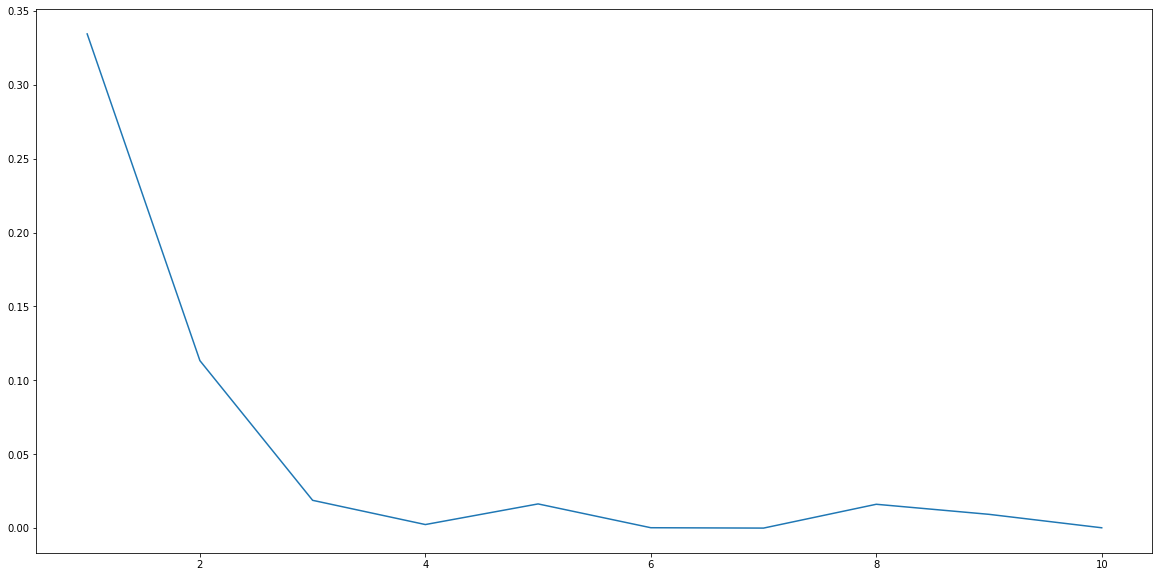

In [73]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 111.565723 	 train accuracy: 0.997750 	 valid accuracy: 0.984000 


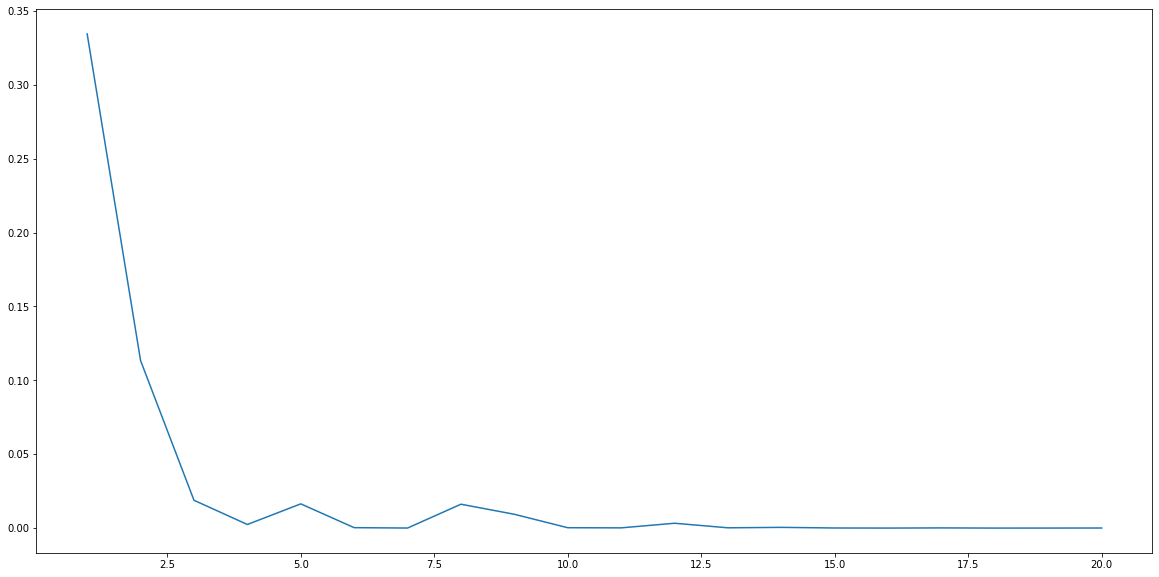

In [74]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 111.813092 	 train accuracy: 0.999375 	 valid accuracy: 0.990250 


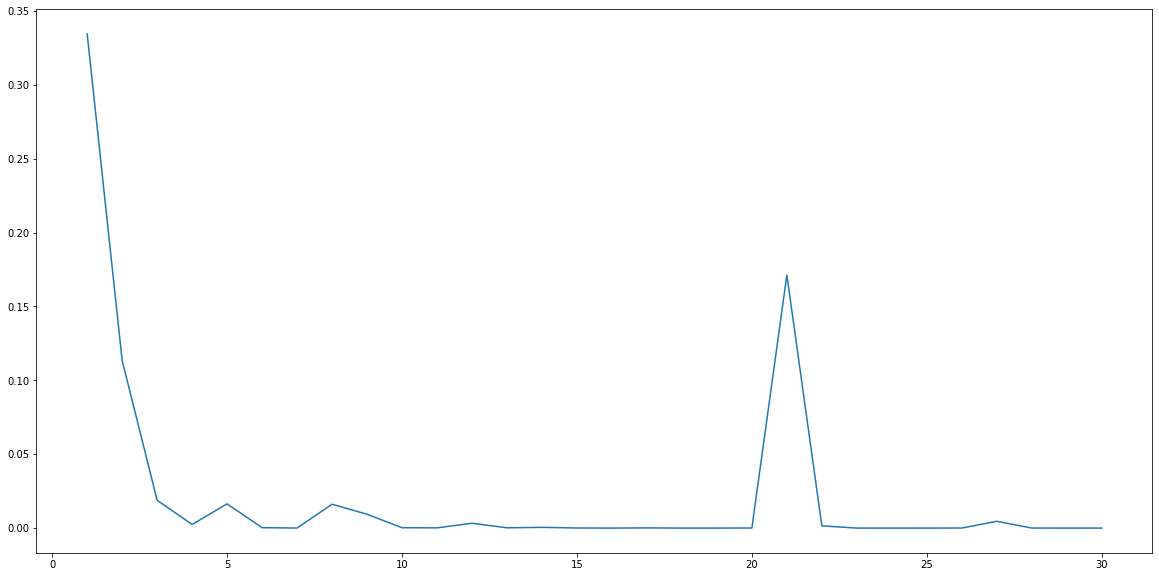

In [75]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 111.864302 	 train accuracy: 1.000000 	 valid accuracy: 0.991500 


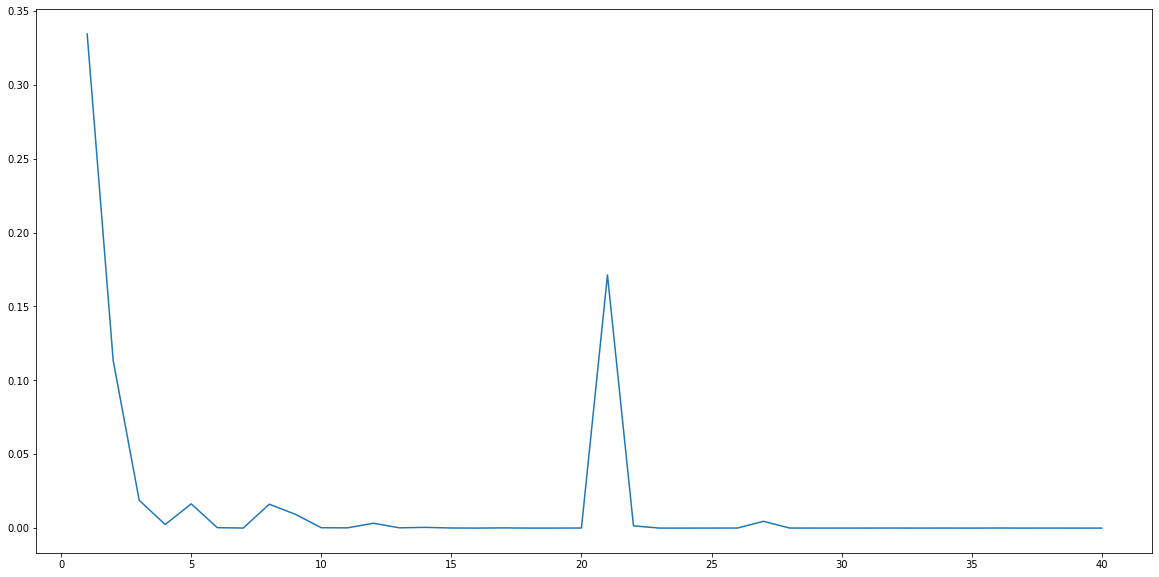

In [77]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

After 30 epochs the model overfits the data (train accuracy is 1.0) but the validation accuracy is highest when train accuracy is 1.0. This is a signal that we can do better by using more data. Generally, we would look for more training data when the train error is below our goal and the validation error is above our goal (see https://www.cs.cornell.edu/courses/cs4780/2021fa/lectures/lecturenote12.html for more details). Here the gap between the train accuracy and validation accuracy is very small but the results in Kaggle competition suggest that we can indeed do better. Instead of the small selection of data on google colab we could use the full data for example from torchvision.datasets.MNIST. For educational reasons (and having Kaggle competition in mind) I choose to create artificial data by applying random shear and rotation to the images in the small dataset. Let us measure the test accuracy and continue with testing different augmentation parameters.

In [78]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.946000


**Data augmentation: rotation**

I will build twice bigger training dataset by creating artifical data. In order to create the artificial data I will apply transformations, which in this section are random rotations in the range of -10 to 10 degrees. This is done with resnet.load_data(train_data_path,split_ratio,2,transformation). The number 2 indicates that the augmented train set will be twice bigger that the original train set.

In [71]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=(-10,10))
resnet.load_data(train_data_path,split_ratio,2,transformation)

training time: 280.491198 	 train accuracy: 0.997000 	 valid accuracy: 0.988750 


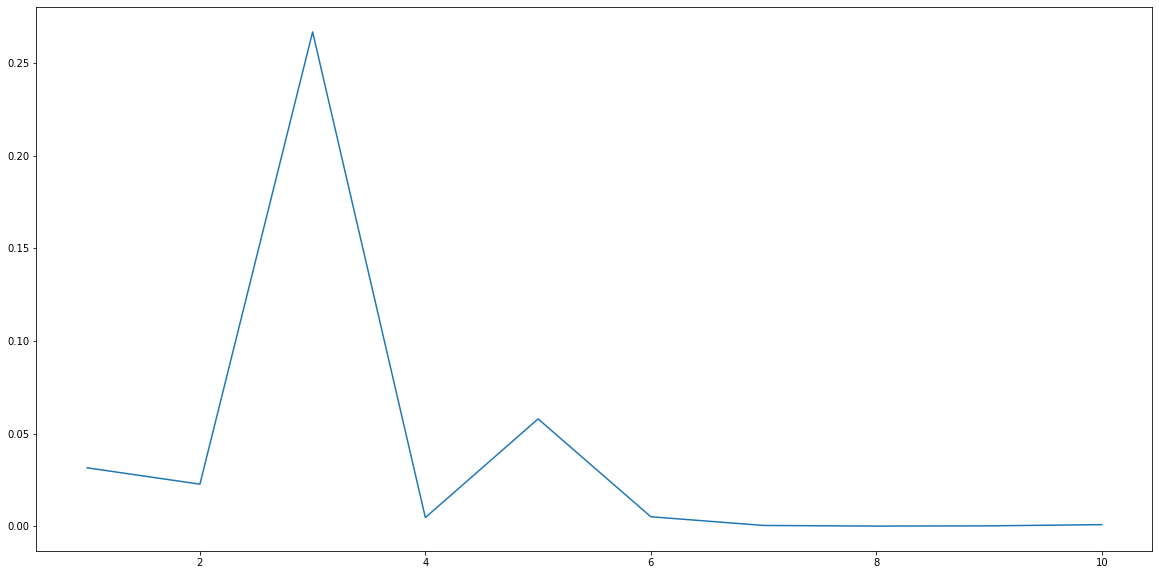

In [12]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 286.116093 	 train accuracy: 0.999094 	 valid accuracy: 0.990250 


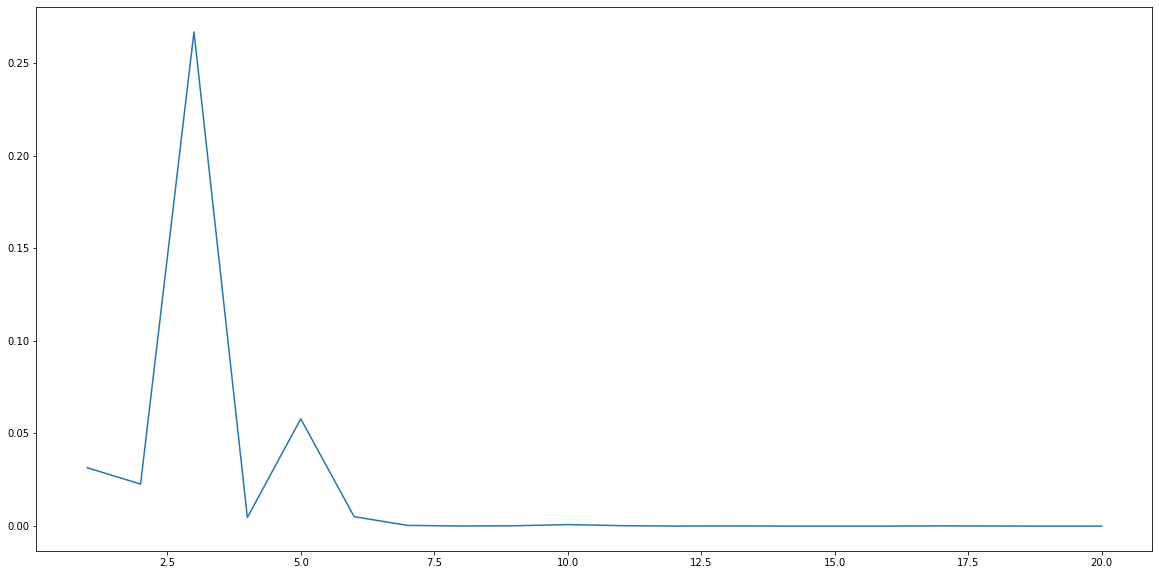

In [13]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 285.723068 	 train accuracy: 0.999688 	 valid accuracy: 0.990000 


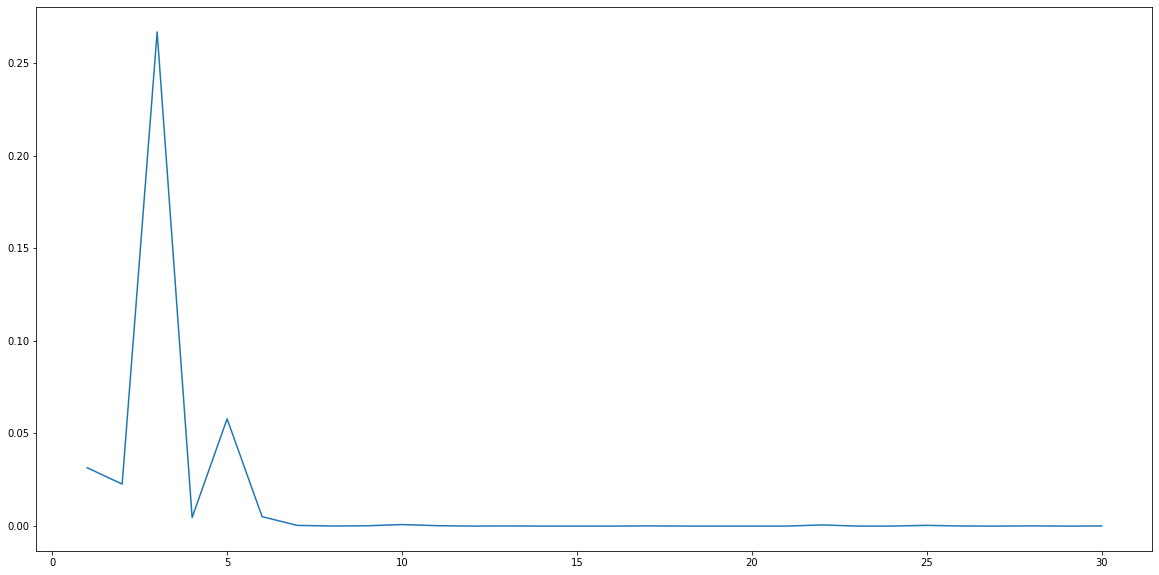

In [14]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 280.347706 	 train accuracy: 0.999156 	 valid accuracy: 0.989000 


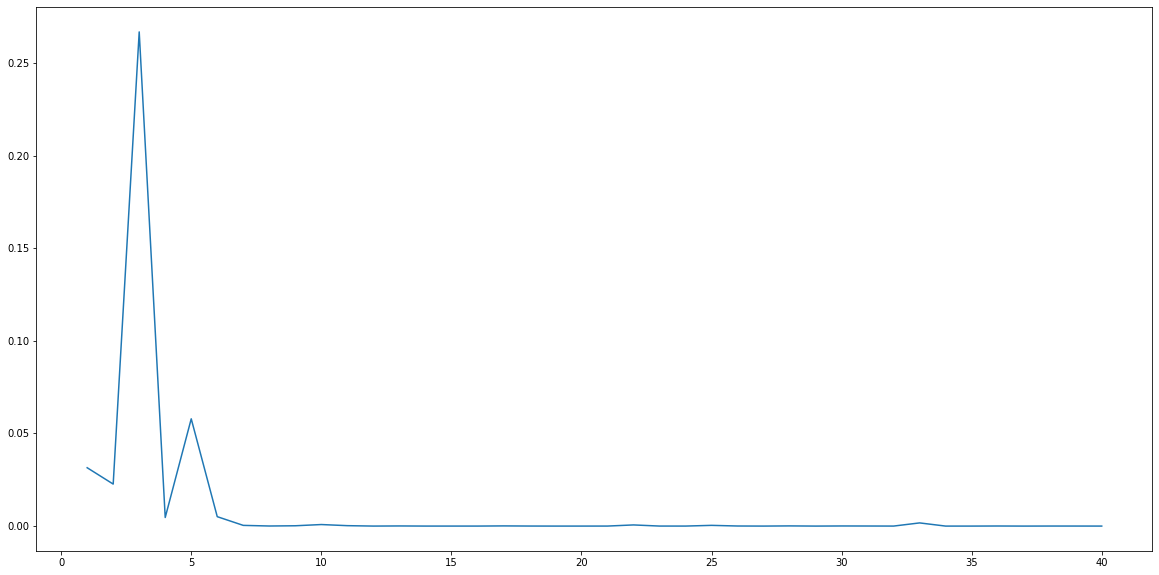

In [15]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 280.665879 	 train accuracy: 0.999750 	 valid accuracy: 0.991000 


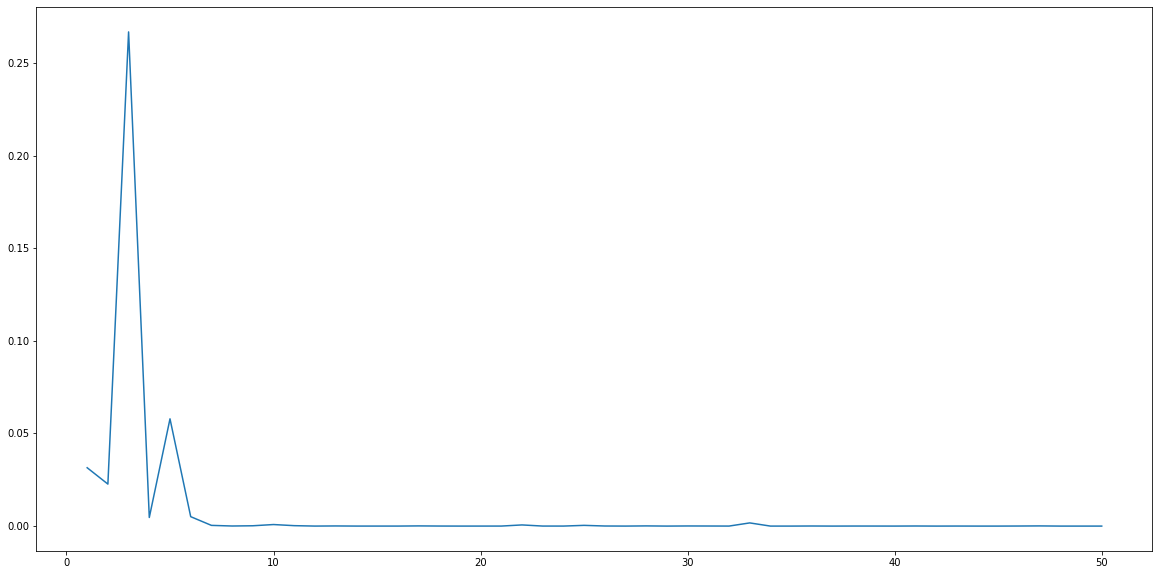

In [16]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 290.989027 	 train accuracy: 0.999906 	 valid accuracy: 0.990500 


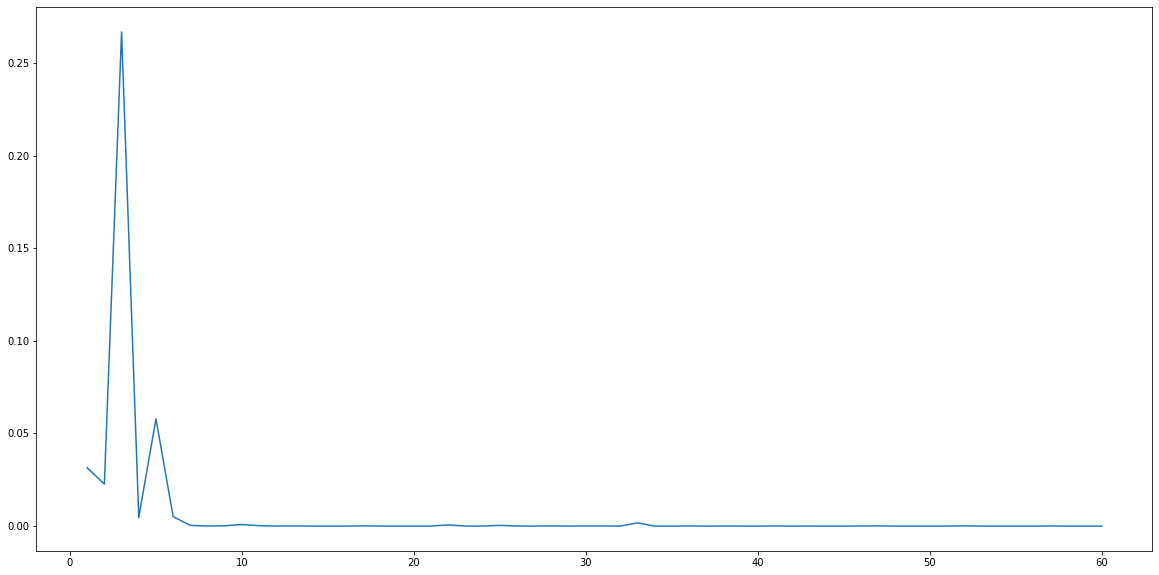

In [17]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 284.504550 	 train accuracy: 1.000000 	 valid accuracy: 0.991750 


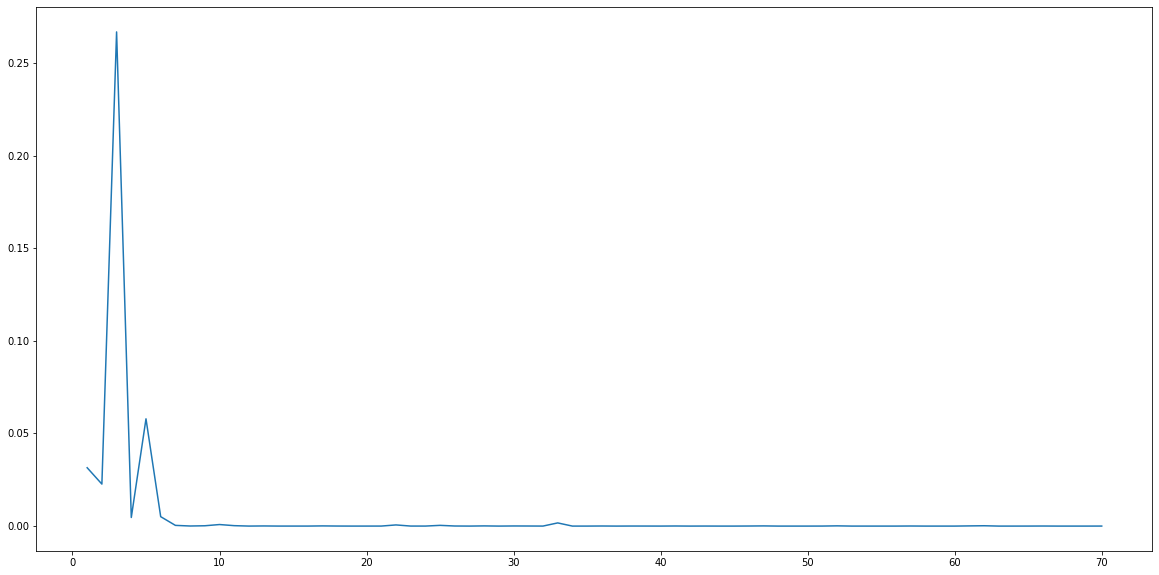

In [18]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [19]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.927900


**Data augmentation: shear**

In this section I will try another augmentation method: I will apply random shear.

In [27]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=0,shear=(-15,15))
resnet.load_data(train_data_path,split_ratio,2,transformation)

training time: 99.046988 	 train accuracy: 0.998531 	 valid accuracy: 0.981000 


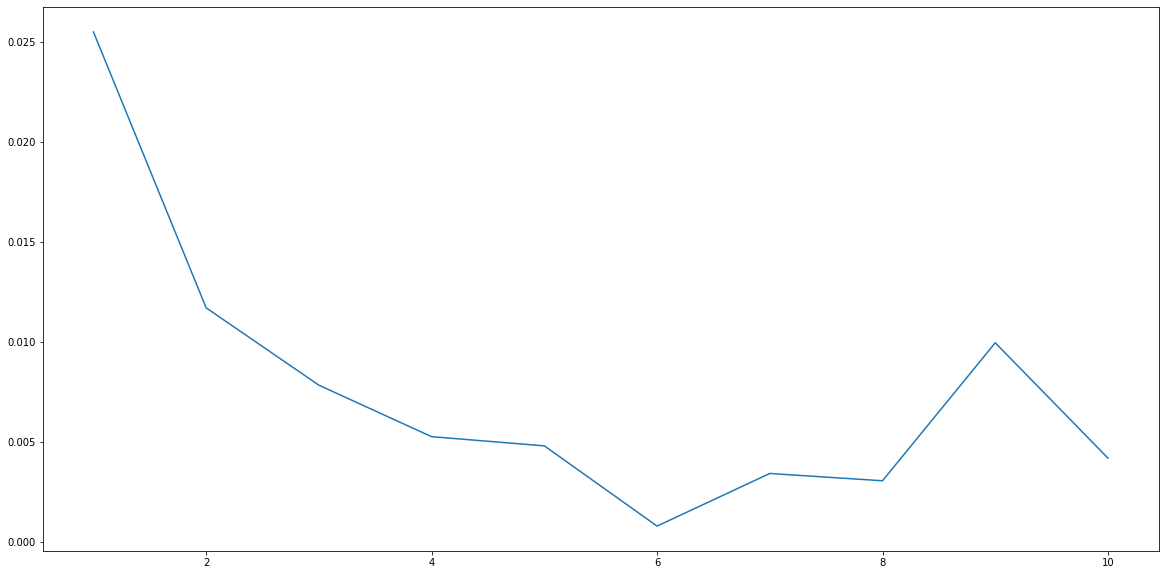

In [28]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 282.083376 	 train accuracy: 0.997969 	 valid accuracy: 0.986750 


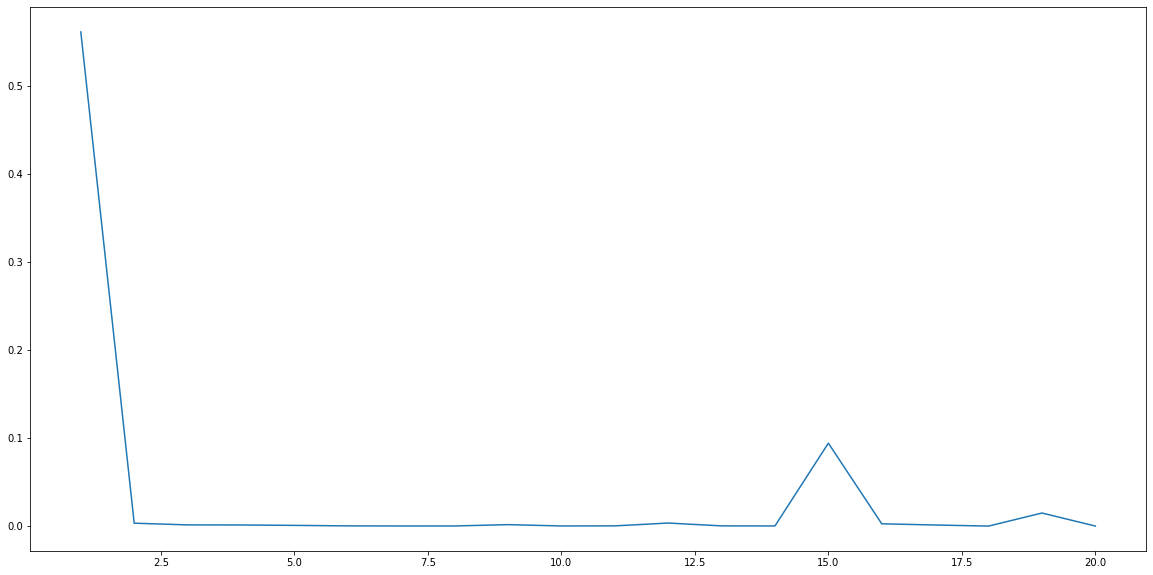

In [22]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 288.088837 	 train accuracy: 0.999719 	 valid accuracy: 0.990500 


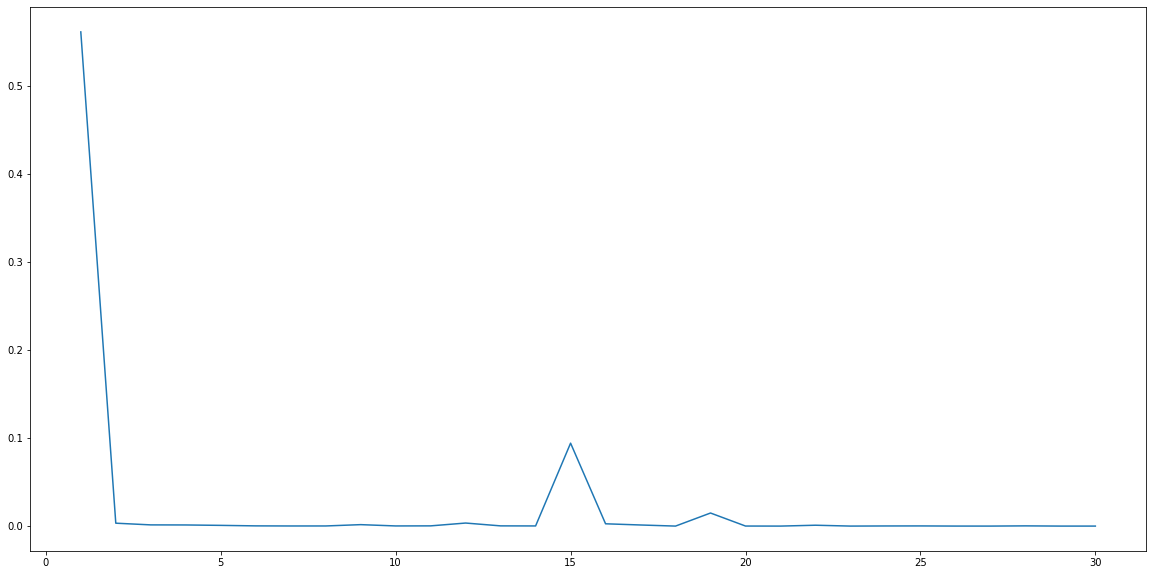

In [23]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 295.223984 	 train accuracy: 0.999875 	 valid accuracy: 0.989750 


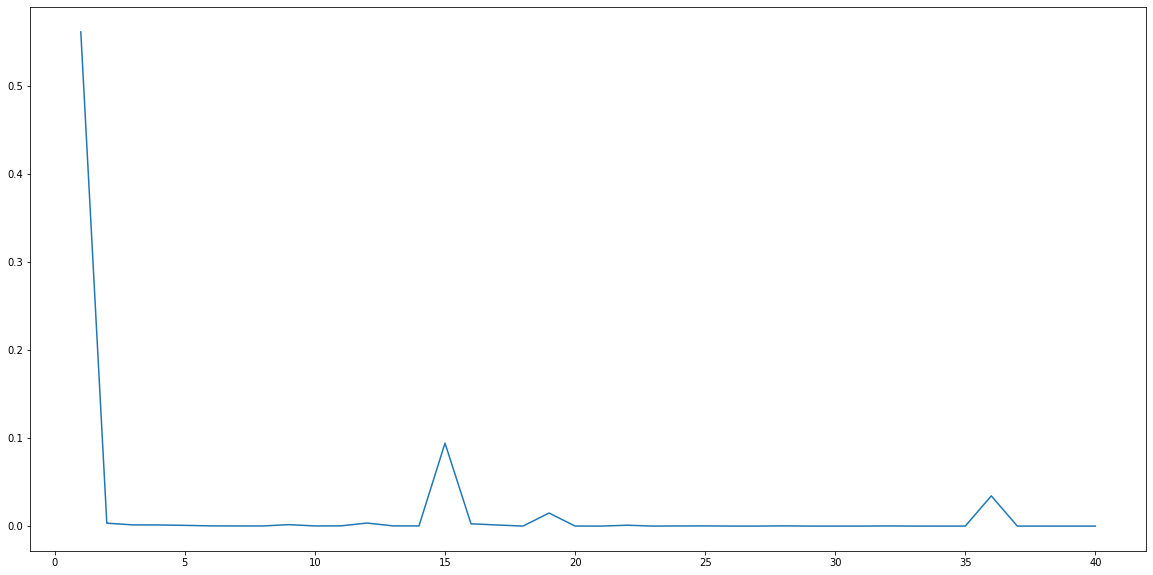

In [24]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 291.494172 	 train accuracy: 1.000000 	 valid accuracy: 0.990500 


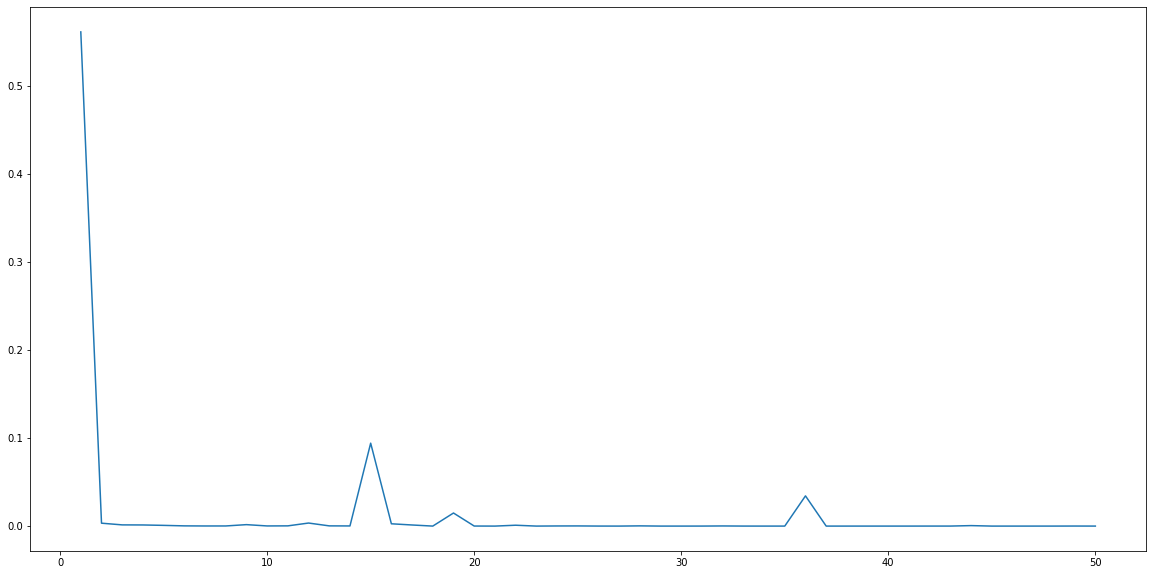

In [25]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [26]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.757400


**Data augmentation: shear + rotation**

In this section I will apply random rotations in the range of -10 to 10 degrees and random shears in the range of -15 to 15 degrees.

In [50]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=(-10,10),shear=(-15,15))
resnet.load_data(train_data_path,split_ratio,2,transformation)

training time: 279.179098 	 train accuracy: 0.996875 	 valid accuracy: 0.987500 


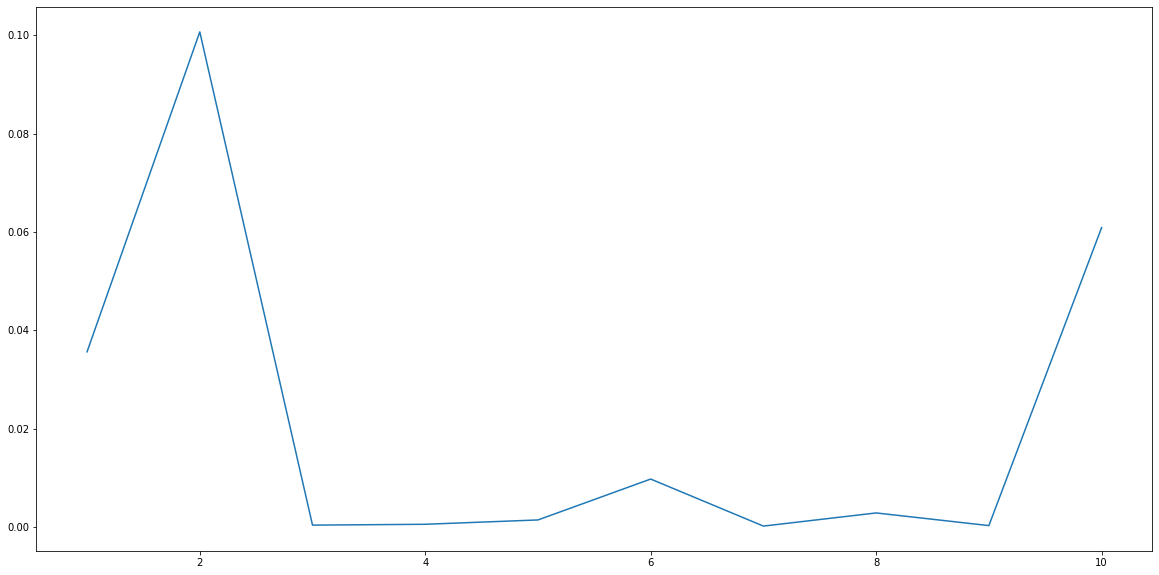

In [51]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 278.027796 	 train accuracy: 0.998875 	 valid accuracy: 0.987500 


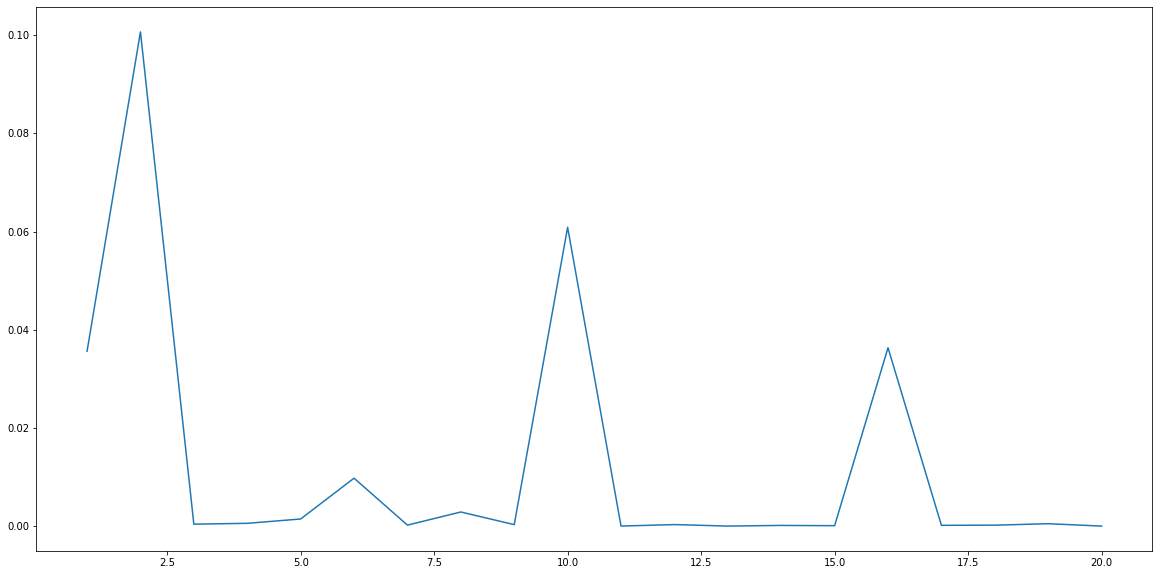

In [52]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 278.901192 	 train accuracy: 0.998938 	 valid accuracy: 0.989750 


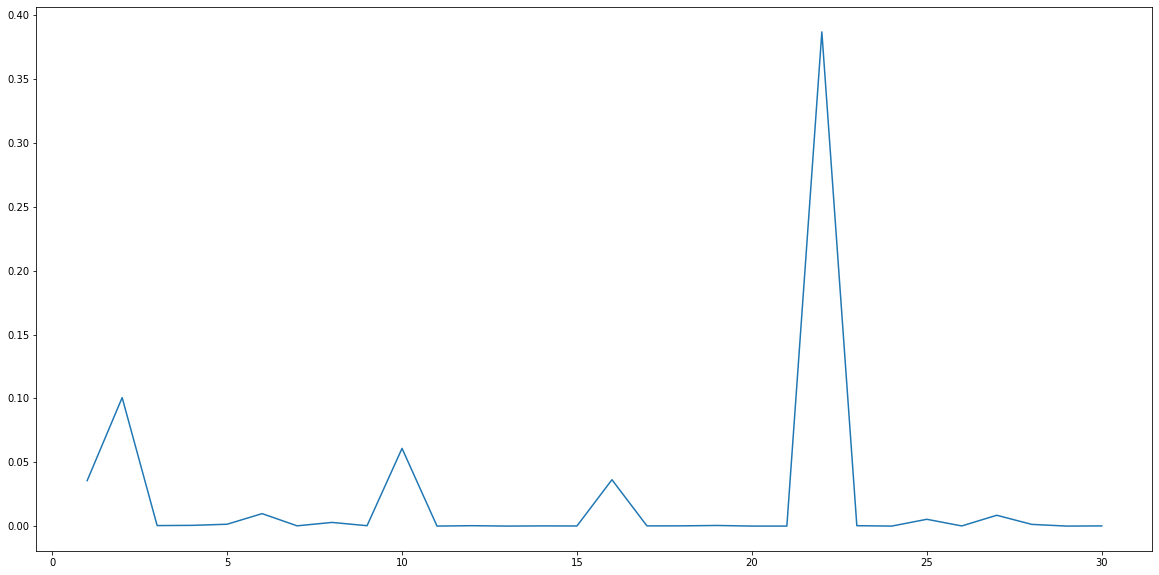

In [53]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 279.253452 	 train accuracy: 0.999063 	 valid accuracy: 0.990250 


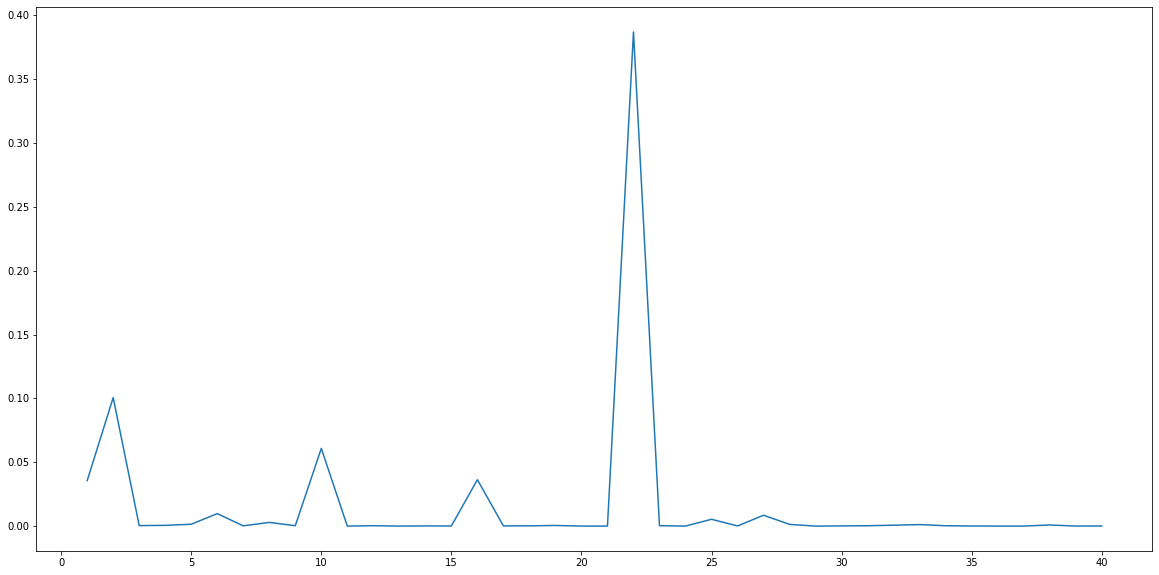

In [54]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 280.151539 	 train accuracy: 0.999875 	 valid accuracy: 0.990750 


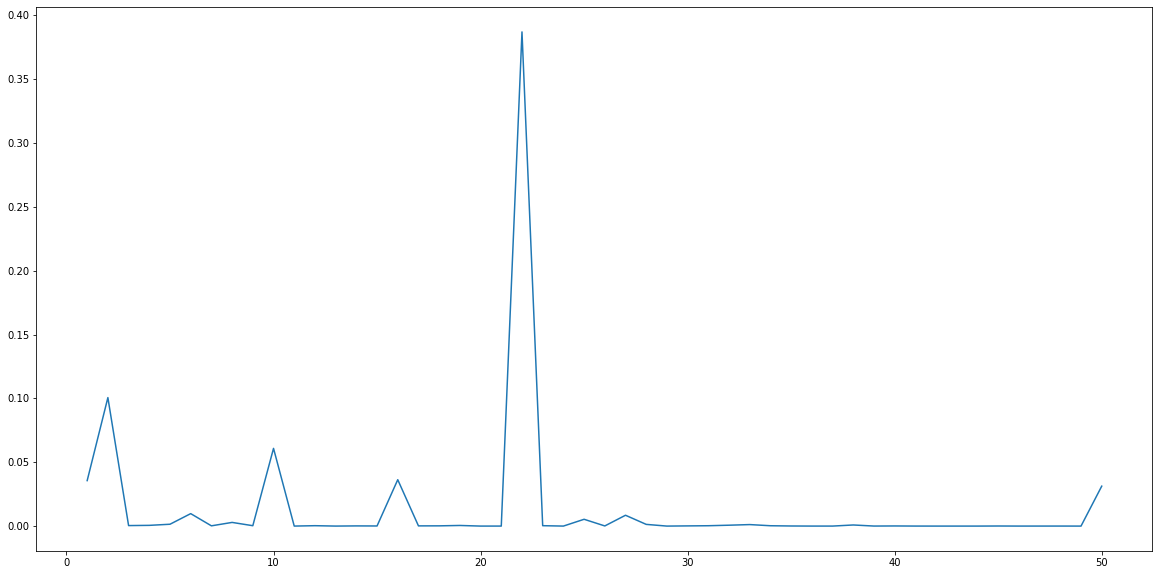

In [55]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 280.195580 	 train accuracy: 0.999906 	 valid accuracy: 0.991250 


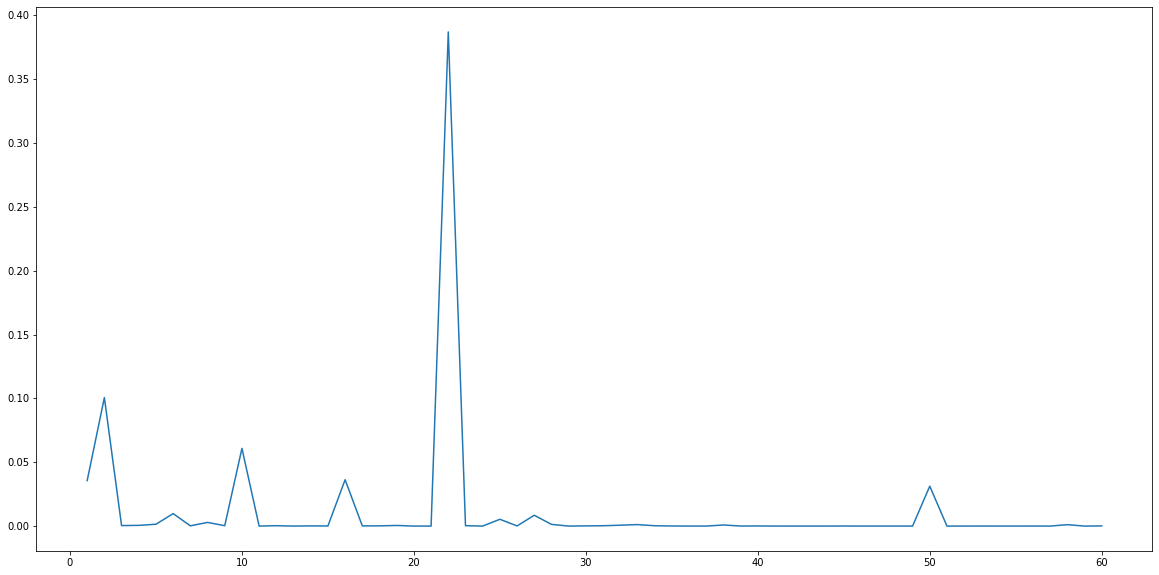

In [57]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 279.713387 	 train accuracy: 0.999969 	 valid accuracy: 0.990750 


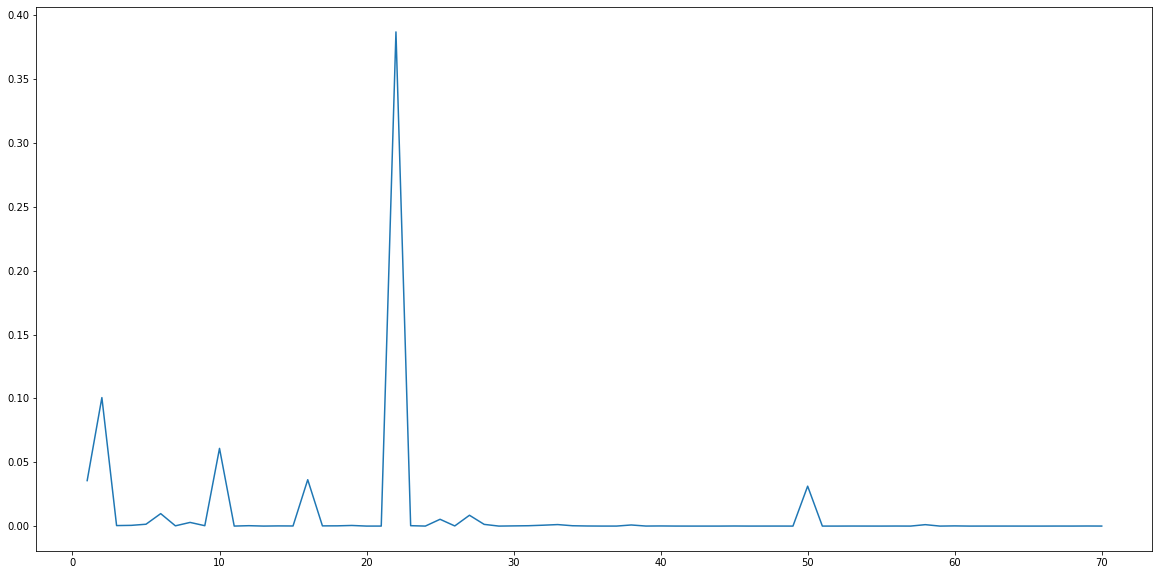

In [59]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 278.565871 	 train accuracy: 0.999938 	 valid accuracy: 0.991000 


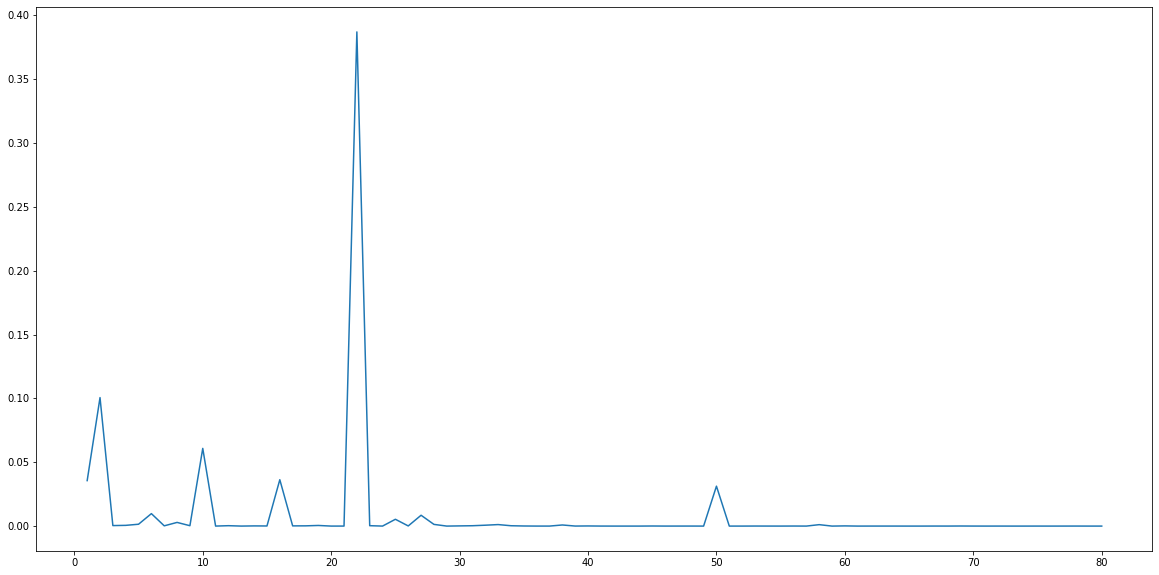

In [61]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 282.669241 	 train accuracy: 1.000000 	 valid accuracy: 0.991000 


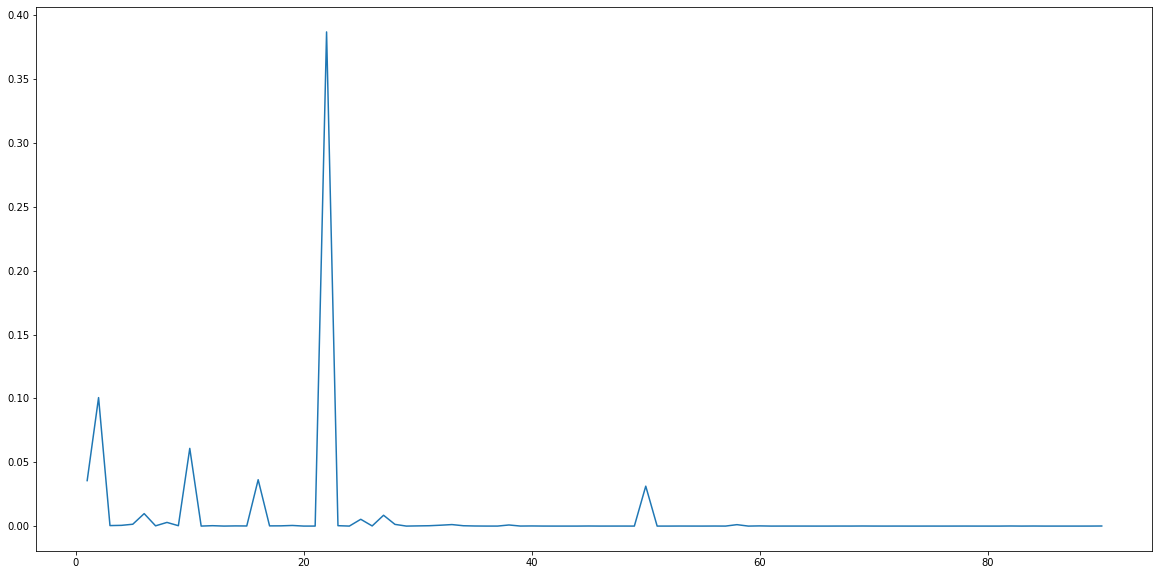

In [63]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [64]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.843500


**Data augmentation: different angles and shears**

I will check how increasing degrees range affects the models performance.

In [ ]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
resnet.load_data(train_data_path,split_ratio,2,torchvision.transforms.RandomAffine(degrees=(-30,30),shear=(-30,30)))

training time: 277.196866 	 train accuracy: 0.992125 	 valid accuracy: 0.987750 


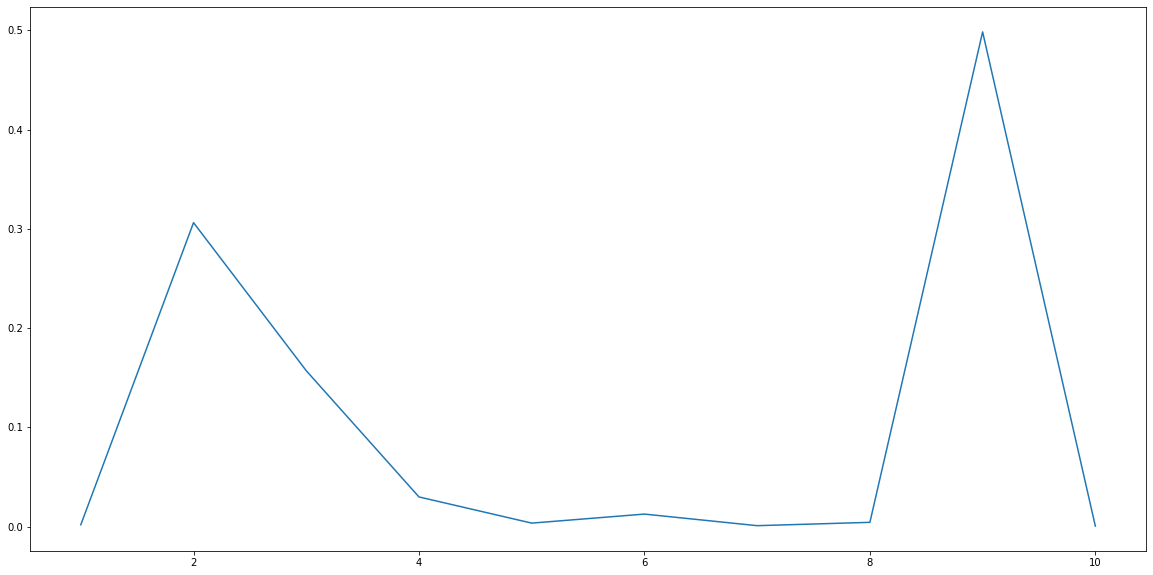

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 276.251508 	 train accuracy: 0.995688 	 valid accuracy: 0.990250 


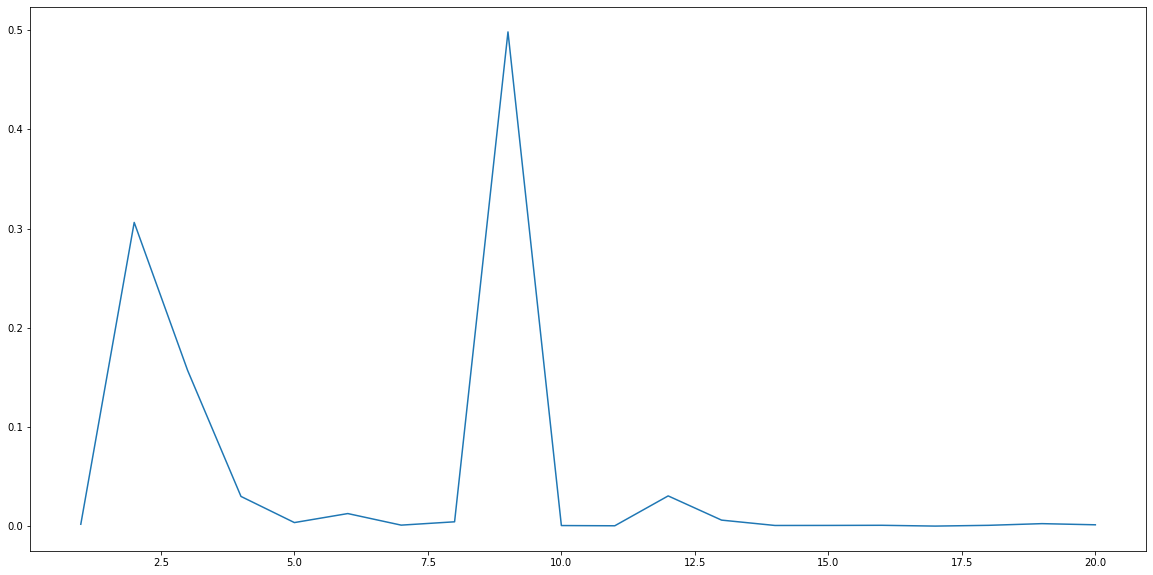

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 274.820903 	 train accuracy: 0.996313 	 valid accuracy: 0.991500 


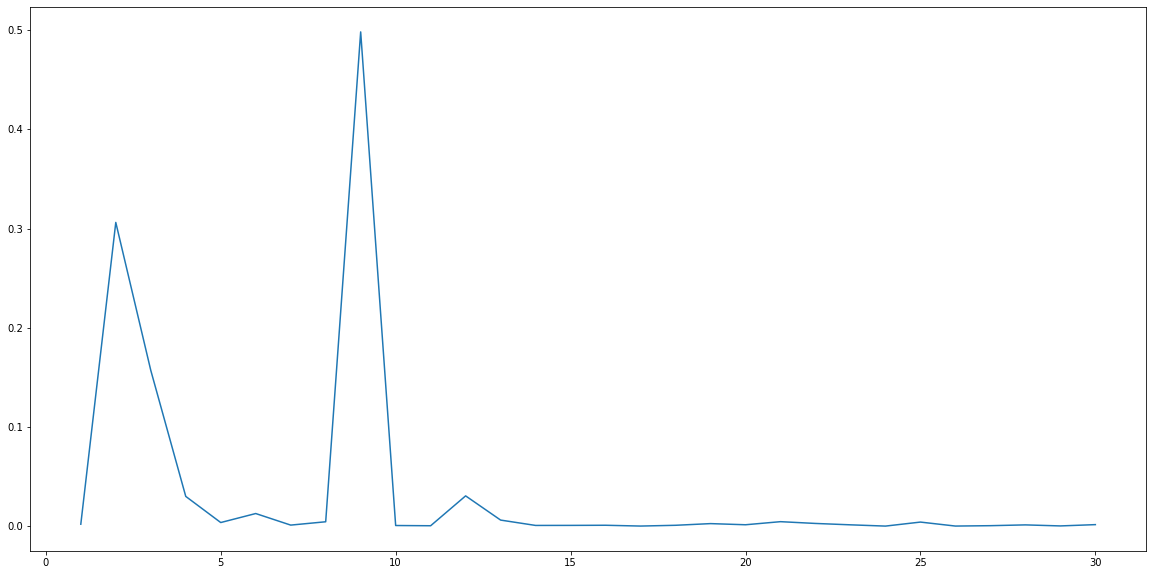

In [ ]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 822.612641 	 train accuracy: 0.996969 	 valid accuracy: 0.991750 


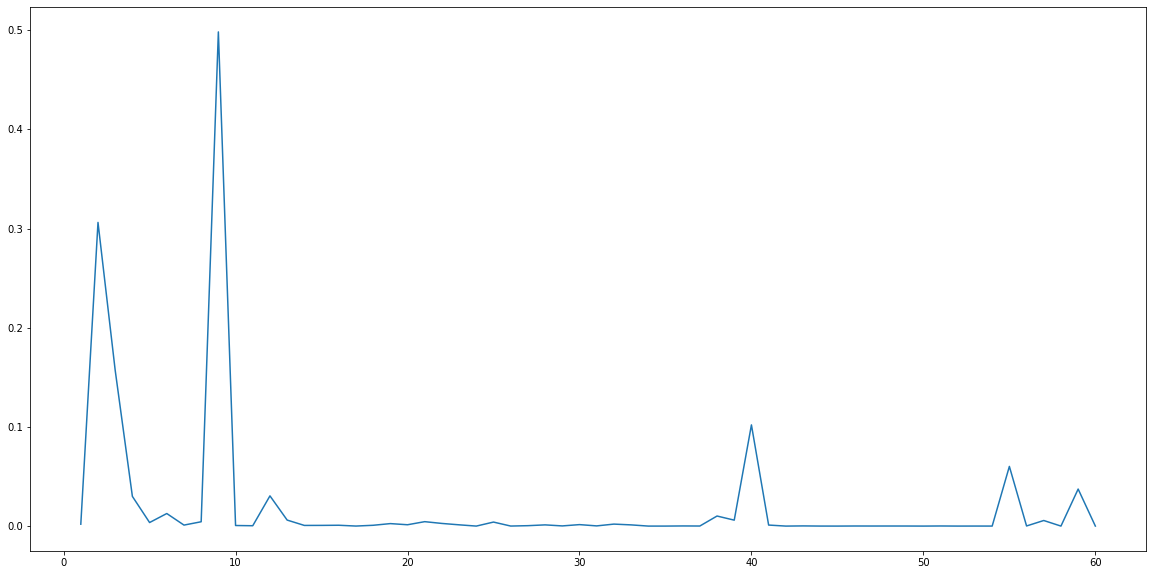

In [ ]:
results=mnist.analyze_model(resnet,16,30)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 274.531640 	 train accuracy: 0.999313 	 valid accuracy: 0.993250 


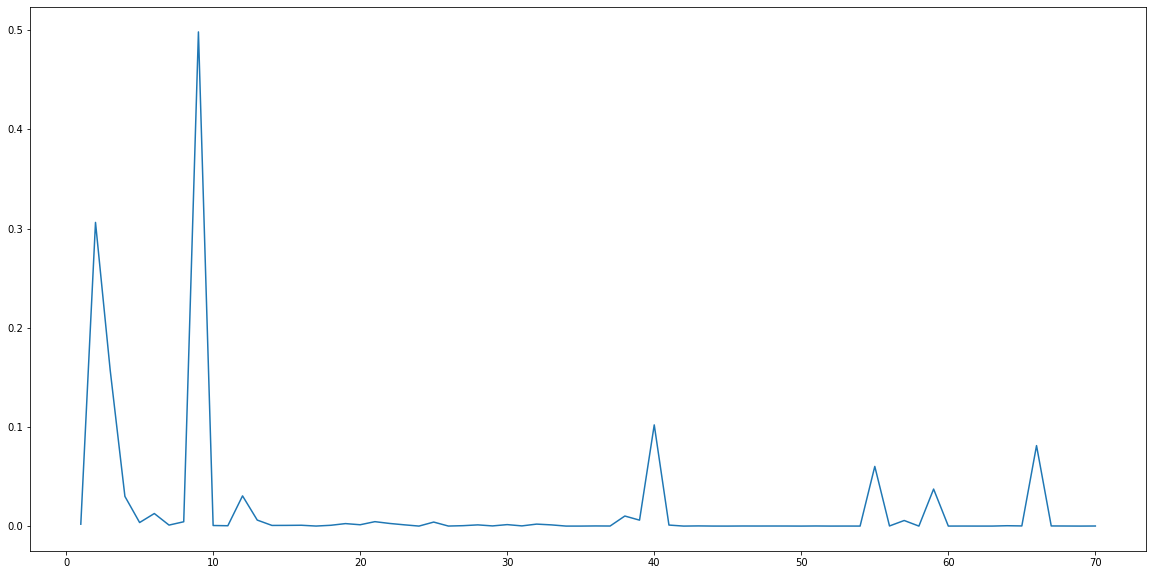

In [ ]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 274.640913 	 train accuracy: 0.999625 	 valid accuracy: 0.992500 


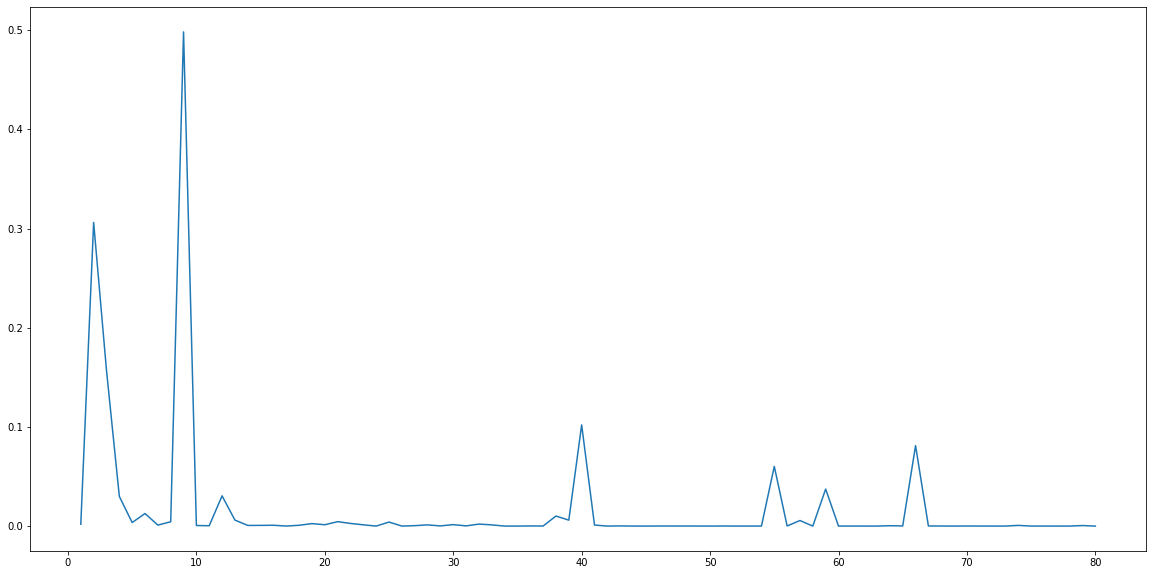

In [ ]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

**Bigger augmentation**

In [79]:
learning_rate=1.0e-01

resnet=mnist.ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
transformation=torchvision.transforms.RandomAffine(degrees=(-15,15),shear=(-15,15))
resnet.load_data(train_data_path,split_ratio,4,transformation)

training time: 597.859097 	 train accuracy: 0.998125 	 valid accuracy: 0.992000 


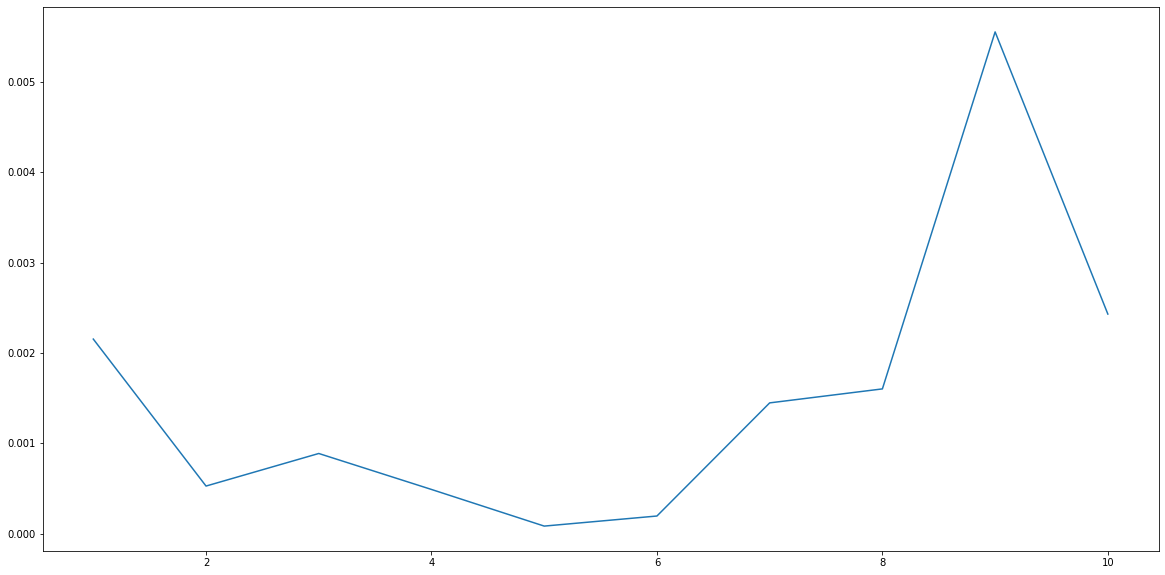

In [80]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 595.904871 	 train accuracy: 0.998984 	 valid accuracy: 0.993000 


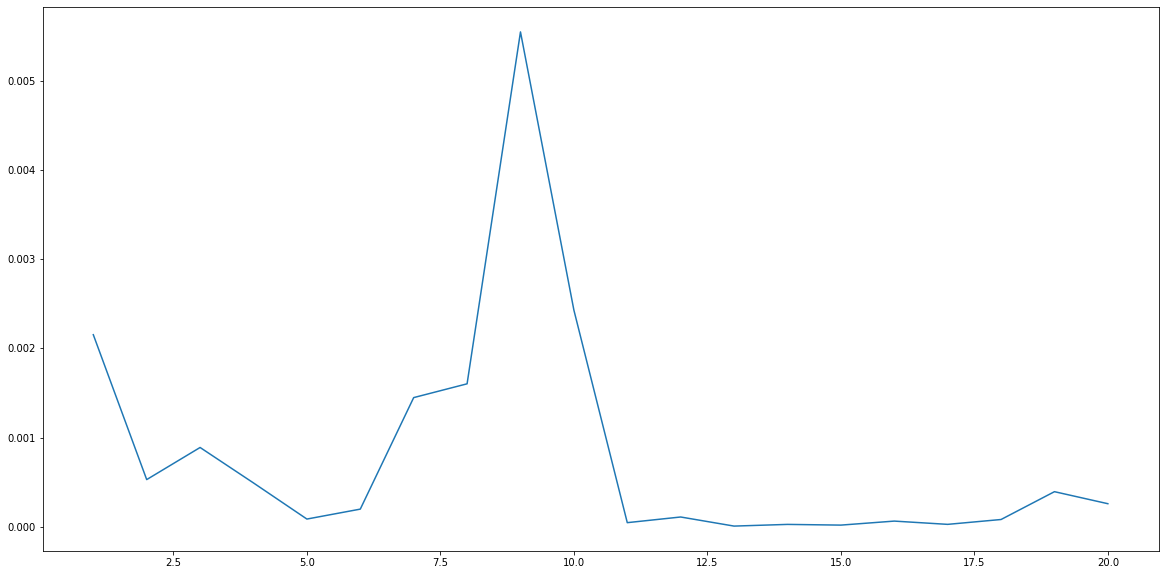

In [81]:
results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 592.819344 	 train accuracy: 0.999719 	 valid accuracy: 0.995750 


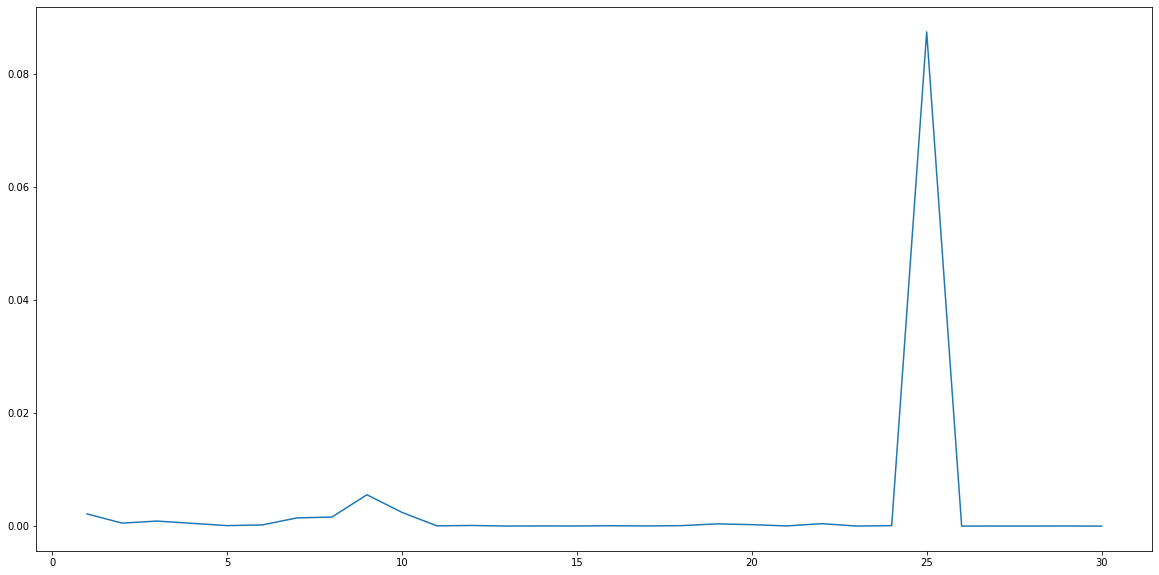

In [82]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)

results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 587.972836 	 train accuracy: 0.999922 	 valid accuracy: 0.995500 


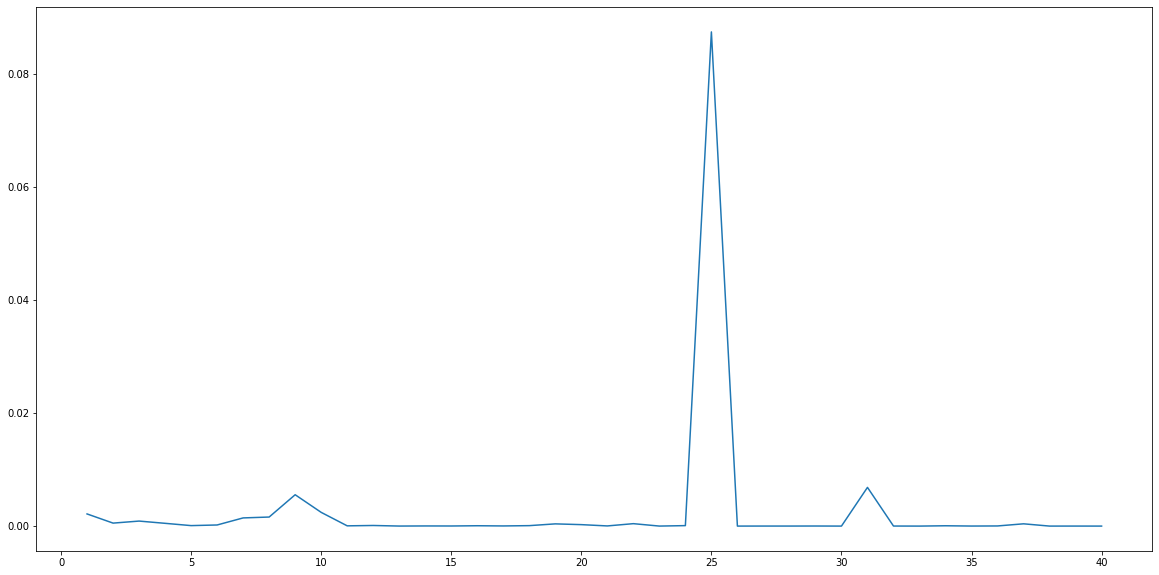

In [85]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)

results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 594.093063 	 train accuracy: 0.999953 	 valid accuracy: 0.995250 


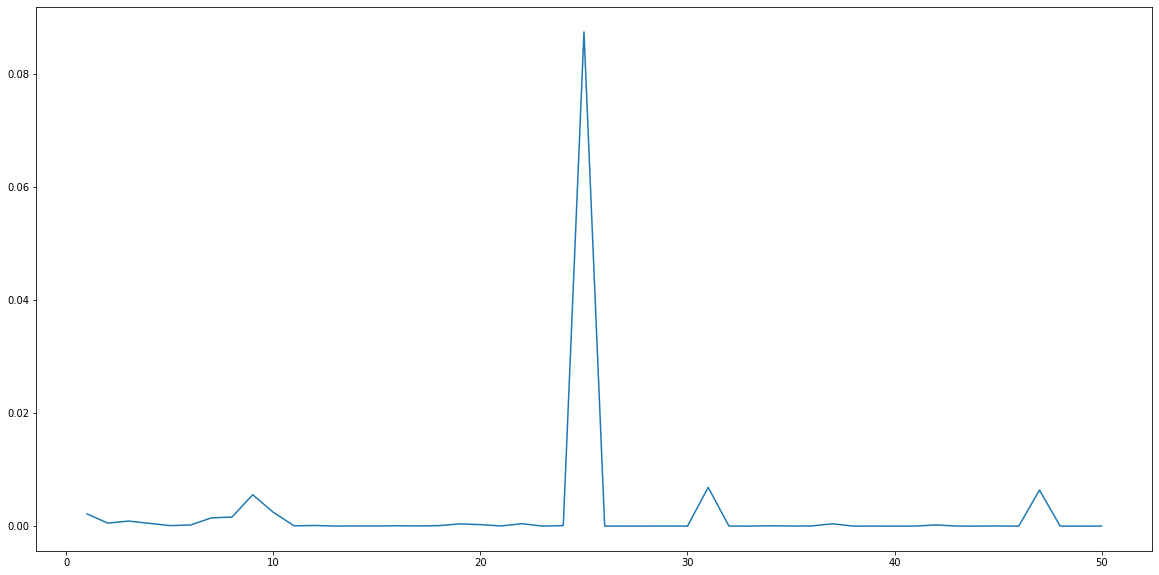

In [89]:
learning_rate=1.0e-02
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)

results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 592.199475 	 train accuracy: 0.999891 	 valid accuracy: 0.995250 


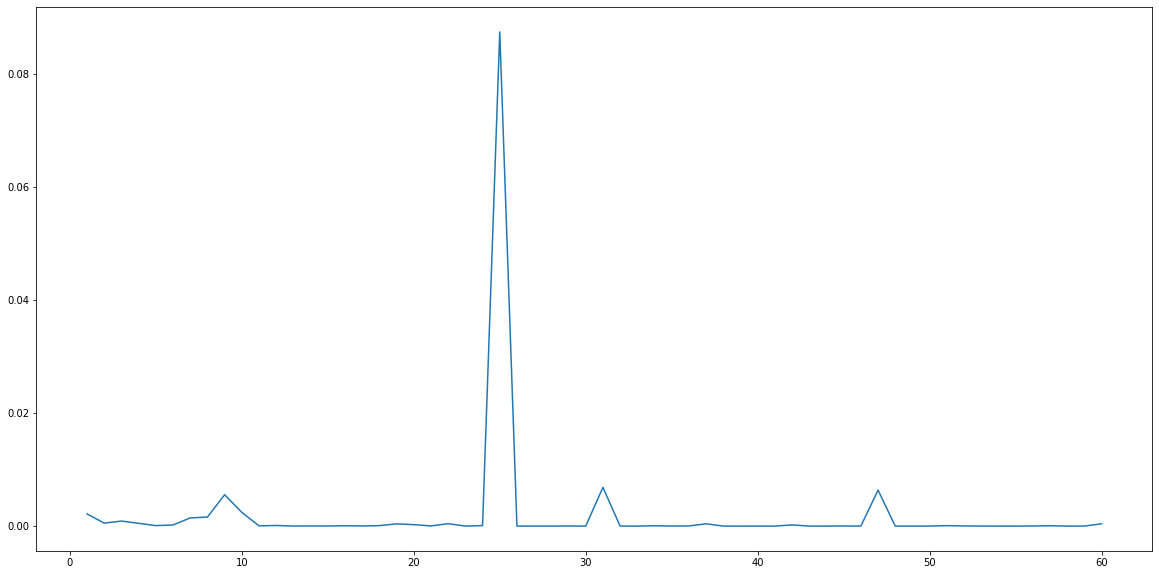

In [90]:
learning_rate=1.0e-03
resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)

results=mnist.analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [91]:
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.994900


In [88]:
test_data.transform=resnet.data_set.transform
print("Test accuracy: %f"%resnet.get_accuracy(test_data))

Test accuracy: 0.994100
